<a href="https://colab.research.google.com/github/Khawaritzmi/Deep-Learning/blob/master/ResNeXt-50%20Architecture%20Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/COVID-19 /covid-19/"

/content/drive/My Drive/COVID-19 /covid-19


%cd "/content/drive/My Drive/Dataset Coklat/Dataset Coklat/Cocoa Beans"

In [0]:
#%tensorflow_version 1.x

In [4]:
import numpy as np
import pickle
import cv2
import keras
import tensorflow as tf

from keras_applications.resnext import ResNeXt50
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()

Using TensorFlow backend.


In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = "/content/drive/My Drive/COVID-19 /covid-19/"
width=224
height=224
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True:
                #if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing normal ...
[INFO] Processing covid ...
[INFO] Image loading completed
CPU times: user 126 µs, sys: 13 µs, total: 139 µs
Wall time: 144 µs


In [8]:
image_size = len(image_list)
print(image_size)

138


In [9]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['covid' 'normal']


In [0]:
label=[]
for i in image_labels:
  if i == [0]:
    label.append([1,0])
  else:
    label.append([0,1])

labels = np.array(label)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, labels, test_size=0.2, random_state = 42)

In [0]:
aug = ImageDataGenerator(
    rotation_range=25.5, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
base_model = ResNeXt50(input_tensor=Input(shape = (width, height, depth)), include_top = False, weights = None, 
        backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

x = base_model.output
#x = GlobalAveragePooling2D()(x)
x = GlobalMaxPool2D()(x)
predictions = Dense(n_classes, activation= 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [15]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [17]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    epochs = EPOCHS, steps_per_epoch=x_train.shape[0] // BS,
    validation_data = (x_test, y_test), 
    callbacks=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)], 
    verbose=2)

Epoch 1/100
 - 24s - loss: 6.4522 - accuracy: 0.4872 - val_loss: 0.7517 - val_accuracy: 0.4286
Epoch 2/100
 - 4s - loss: 7.3637 - accuracy: 0.5208 - val_loss: 0.8168 - val_accuracy: 0.4286
Epoch 3/100
 - 3s - loss: 5.6491 - accuracy: 0.5128 - val_loss: 0.8407 - val_accuracy: 0.4286
Epoch 4/100
 - 3s - loss: 5.2761 - accuracy: 0.4487 - val_loss: 0.9627 - val_accuracy: 0.4286
Epoch 5/100
 - 3s - loss: 3.9881 - accuracy: 0.6923 - val_loss: 1.1186 - val_accuracy: 0.4286
Epoch 6/100
 - 3s - loss: 1.9152 - accuracy: 0.7821 - val_loss: 1.3802 - val_accuracy: 0.4286
Epoch 7/100
 - 4s - loss: 2.8053 - accuracy: 0.7396 - val_loss: 1.5270 - val_accuracy: 0.4286
Epoch 8/100
 - 3s - loss: 2.0161 - accuracy: 0.8333 - val_loss: 1.7201 - val_accuracy: 0.4286
Epoch 9/100
 - 4s - loss: 1.4695 - accuracy: 0.8854 - val_loss: 2.0555 - val_accuracy: 0.4286
Epoch 10/100
 - 3s - loss: 2.3755 - accuracy: 0.8000 - val_loss: 2.3662 - val_accuracy: 0.4286
Epoch 11/100
 - 4s - loss: 3.1689 - accuracy: 0.7396 - val

In [18]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

28/28 [==============================] - 0s 9ms/step
Test Accuracy: 42.85714328289032


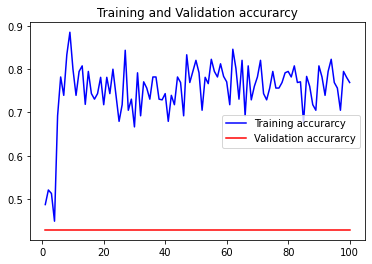

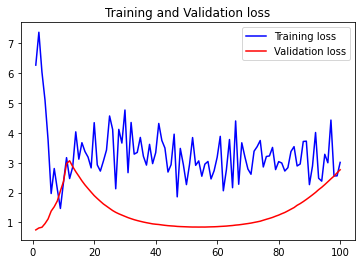

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()